In [ ]:
print("TensorFlow version:", tf.__version__)
print("TF-Agents version:", tf_agents.__version__)

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import tempfile
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm
from typing import Optional, Callable, Text
import typing_extensions

from tf_agents.agents import tf_agent, data_converter
from tf_agents.agents.ddpg import ddpg_agent, actor_network, critic_network
from tf_agents.agents.td3 import td3_agent
from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.ppo import ppo_agent
from tf_agents.environments import suite_gym, tf_py_environment
from tf_agents.networks import actor_distribution_network, value_network, q_network
from tf_agents.specs import tensor_spec
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import trajectory, time_step as ts
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.policies import actor_policy, greedy_policy, q_policy, epsilon_greedy_policy
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.drivers import dynamic_step_driver, dynamic_episode_driver
from tf_agents.distributions import utils as distribution_utils
from tf_agents.agents.sac import sac_agent
from tf_agents.typing import types
import collections
import gin
import tf_agents.networks as network

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import tensorflow as tf

# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available.")
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    print(f"{len(physical_devices)} GPUs detected.")
    
    # List all available devices
    for i, device in enumerate(physical_devices):
        print(f'Device {i}:', device)
else:
    print("GPU is not available.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is not available.


In [2]:
Literal = typing_extensions.Literal


class BehavioralCloningLossInfo(collections.namedtuple(
    'BehavioralCloningLossInfo', ('loss'))):
  pass


@gin.configurable
class BehavioralCloningAgent(tf_agent.TFAgent):
  

  def __init__(
      self,
      time_step_spec: ts.TimeStep,
      action_spec: types.NestedTensorSpec,
      cloning_network: network.Network,
      optimizer: types.Optimizer,
      num_outer_dims: Literal[1, 2] = 2,  # pylint: disable=bad-whitespace
      epsilon_greedy: types.Float = 0.1,
      loss_fn: Optional[Callable[[types.NestedTensor, bool],
                                 types.Tensor]] = None,
      gradient_clipping: Optional[types.Float] = None,
      # Params for debugging.
      debug_summaries: bool = False,
      summarize_grads_and_vars: bool = False,
      train_step_counter: Optional[tf.Variable] = None,
      name: Optional[Text] = None):
    
    tf.Module.__init__(self, name=name)
    self._cloning_network = cloning_network
    self._optimizer = optimizer
    self._gradient_clipping = gradient_clipping

    action_spec = tensor_spec.from_spec(action_spec)
    flat_action_spec = tf.nest.flatten(action_spec)
    continuous_specs = [tensor_spec.is_continuous(s) for s in flat_action_spec]

    if not flat_action_spec:
      raise ValueError('The `action_spec` must contain at least one action.')

    single_discrete_scalar_action = (
        len(flat_action_spec) == 1 and
        flat_action_spec[0].shape.rank == 0 and
        not tensor_spec.is_continuous(flat_action_spec[0]))
    single_continuous_action = (
        len(flat_action_spec) == 1 and
        tensor_spec.is_continuous(flat_action_spec[0]))

    if (not loss_fn and not single_discrete_scalar_action and
        not single_continuous_action):
      raise ValueError(
          'A `loss_fn` must be provided unless there is a single, scalar '
          'discrete action or a single (scalar or non-scalar) continuous '
          'action.')

    self._network_output_spec = cloning_network.create_variables(
        time_step_spec.observation)

    # If there is a mix of continuous and discrete actions we want to use an
    # actor policy so we can use the `setup_as_continuous` method as long as the
    # user provided a custom loss_fn which we verified above.
    if any(continuous_specs):
      policy, collect_policy = self._setup_as_continuous(
          time_step_spec, action_spec, loss_fn)
    else:
      policy, collect_policy = self._setup_as_discrete(time_step_spec,
                                                       action_spec, loss_fn,
                                                       epsilon_greedy)

    super(BehavioralCloningAgent, self).__init__(
        time_step_spec,
        action_spec,
        policy,
        collect_policy,
        train_sequence_length=None,
        debug_summaries=debug_summaries,
        summarize_grads_and_vars=summarize_grads_and_vars,
        train_step_counter=train_step_counter)

    self._as_trajectory = data_converter.AsTrajectory(
        self.data_context, sequence_length=None,
        num_outer_dims=num_outer_dims)

  @property
  def cloning_network(self):
    return self._cloning_network

  def _discrete_loss(self, experience, training=False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])

    network_state = self._cloning_network.get_initial_state(batch_size)
    action, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    # Get logits if the output of the cloning network is a distribution.
    if isinstance(action, tfp.distributions.Distribution):
      bc_logits = action.logits_parameter()
    else:
      bc_logits = action

    def loss(action, bc_logits, spec):
      # Subtract the minimum so that we get a proper cross entropy loss on
      # [0, maximum - minimum).
      return tf.nn.sparse_softmax_cross_entropy_with_logits(
          labels=action - spec.minimum, logits=bc_logits)

    losses = tf.nest.map_structure(loss, experience.action, bc_logits,
                                   self.action_spec)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _continuous_loss_fn(self, experience, training: bool = False):
    batch_size = (
        tf.compat.dimension_value(experience.step_type.shape[0]) or
        tf.shape(experience.step_type)[0])
    network_state = self._cloning_network.get_initial_state(batch_size)
    bc_output, _ = self._cloning_network(
        experience.observation,
        step_type=experience.step_type,
        training=training,
        network_state=network_state)

    if isinstance(bc_output, tfp.distributions.Distribution):
      bc_action = bc_output.sample()
    else:
      bc_action = bc_output

    losses = tf.nest.map_structure(tf.losses.mse, experience.action, bc_action)
    losses = tf.nest.flatten(losses)
    return tf.add_n(losses)

  def _setup_as_discrete(self, time_step_spec, action_spec, loss_fn,
                         epsilon_greedy):
    self._bc_loss_fn = loss_fn or self._discrete_loss

    if any(isinstance(d, distribution_utils.DistributionSpecV2) for
           d in tf.nest.flatten([self._network_output_spec])):
      # If the output of the cloning network contains a distribution.
      base_policy = actor_policy.ActorPolicy(time_step_spec, action_spec,
                                             self._cloning_network)
    else:
      # If the output of the cloning network is logits.
      base_policy = q_policy.QPolicy(
          time_step_spec,
          action_spec,
          q_network=self._cloning_network,
          validate_action_spec_and_network=False)
    policy = greedy_policy.GreedyPolicy(base_policy)
    collect_policy = epsilon_greedy_policy.EpsilonGreedyPolicy(
        base_policy, epsilon=epsilon_greedy)
    return policy, collect_policy

  def _setup_as_continuous(self, time_step_spec, action_spec, loss_fn):
    self._bc_loss_fn = loss_fn or self._continuous_loss_fn
    collect_policy = actor_policy.ActorPolicy(
        time_step_spec, action_spec, actor_network=self._cloning_network)
    policy = greedy_policy.GreedyPolicy(collect_policy)
    return policy, collect_policy

  def _loss(self, experience, weights=None, training: bool = False):
    experience = self._as_trajectory(experience)

    per_example_loss = self._bc_loss_fn(experience, training=training)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup
    aggregated_losses = common.aggregate_losses(
        per_example_loss=per_example_loss,
        sample_weight=weights,
        regularization_loss=self._cloning_network.losses)

    return tf_agent.LossInfo(
        loss=aggregated_losses.total_loss,
        extra=BehavioralCloningLossInfo(per_example_loss))

  def _train(self, experience, weights=None):
    experience = self._as_trajectory(experience)

    with tf.GradientTape() as tape:
      per_example_loss = self._bc_loss_fn(experience, training=True)  # pytype: disable=wrong-keyword-args  # dynamic-method-lookup

      aggregated_losses = common.aggregate_losses(
          per_example_loss=per_example_loss,
          sample_weight=weights,
          regularization_loss=self._cloning_network.losses)

    self._apply_loss(aggregated_losses,
                     variables_to_train=self._cloning_network.trainable_weights,
                     tape=tape,
                     optimizer=self._optimizer)

    self.train_step_counter.assign_add(1)
    return tf_agent.LossInfo(aggregated_losses.total_loss,
                             BehavioralCloningLossInfo(per_example_loss))

In [3]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [56]:
def plot_results(losses, average_returns):
    # Convert actions_taken to a 1D list
    #actions_taken = [item[0][0] for item in actions_taken]
    # Plotting losses
    steps, loss_vals = zip(*losses)
    plt.figure()
    plt.plot(steps, loss_vals)
    plt.title('Loss over time')
    plt.xlabel('Time step')
    plt.ylabel('Loss')
    plt.show()

    # Plotting average returns
    steps, avg_returns = zip(*average_returns)
    plt.figure()
    plt.plot(steps, avg_returns)
    plt.title('Average Return over time')
    plt.xlabel('Time step')
    plt.ylabel('Average Return')
    plt.show()

In [5]:
def plot_average_episode_length(episode_lengths, eval_interval):
    """Plot the average episode length over time."""
    steps = list(range(0, len(episode_lengths) * eval_interval, eval_interval))
    plt.figure(figsize=(10, 5))
    plt.plot(steps, episode_lengths)
    plt.xlabel('Training Steps')
    plt.ylabel('Average Episode Length')
    plt.title('Average Episode Length over Training Steps')
    plt.grid(True)
    plt.show()

### SAC

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = 'cuda:0'

env_name = 'LunarLanderContinuous-v2'
train_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_env)

In [7]:
eval_env_name = 'LunarLanderContinuous-v2'
eval_env = suite_gym.load(eval_env_name)
eval_env = tf_py_environment.TFPyEnvironment(eval_env)

In [17]:
# Parameters
num_iterations = 10000
initial_collect_steps = 1000
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000
batch_size = 64
learning_rate = 1e-3
log_interval = 50
eval_interval = 100
num_eval_episodes = 10 

# Hyperparameters
critic_learning_rate = 3e-4
actor_learning_rate = 3e-4
alpha_learning_rate = 3e-4
target_update_tau = 0.005
target_update_period = 1
gamma = 0.99
reward_scale_factor = 1.0
gradient_clipping = None
debug_summaries = False
summarize_grads_and_vars = False

In [10]:
# Actor network
sac_actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(256, 256))

In [11]:
# Critic network
sac_critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(), train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(256, 256))

In [12]:
# SAC Agent
global_step = tf.compat.v1.train.get_or_create_global_step()
sac_tf_agent = sac_agent.SacAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=sac_actor_net,
    critic_network=sac_critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=actor_learning_rate),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=critic_learning_rate),
    alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
        learning_rate=alpha_learning_rate),
    target_update_tau=target_update_tau,
    target_update_period=target_update_period,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    reward_scale_factor=reward_scale_factor,
    gradient_clipping=gradient_clipping,
    debug_summaries=debug_summaries,
    summarize_grads_and_vars=summarize_grads_and_vars,
    train_step_counter=global_step)
sac_tf_agent.initialize()

In [13]:
# Replay Buffer
sac_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=sac_tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [13]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    buffer.add_batch(traj)

In [15]:
for _ in range(1000):
    collect_step(train_env, sac_tf_agent.collect_policy, sac_replay_buffer)

In [16]:
sac_dataset = sac_replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

sac_iterator = iter(sac_dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [17]:
# Variables to store data for plotting
actions_taken = []
losses = []
average_returns = []
episode_lengths = []

# For tracking episode length
episode_length = 0

# Assuming `num_iterations` is the total number of training steps
for _ in (range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, sac_tf_agent.collect_policy, sac_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(sac_iterator)
  train_loss = sac_tf_agent.train(experience).loss

  step = sac_tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, sac_tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    average_returns.append((step, avg_return))

step = 50: loss = 157.61593627929688
step = 100: loss = 356.8287658691406
step = 100: Average Return = -788.7340698242188
step = 150: loss = 4.4430365562438965
step = 200: loss = 494.5775451660156
step = 200: Average Return = -749.7868041992188
step = 250: loss = 5.9950151443481445
step = 300: loss = 161.2626190185547
step = 300: Average Return = -662.5162353515625
step = 350: loss = 7.691943645477295
step = 400: loss = 266.7491760253906
step = 400: Average Return = -602.00341796875
step = 450: loss = 5.344083309173584
step = 500: loss = 8.645339012145996
step = 500: Average Return = -298.8942565917969
step = 550: loss = 55.567596435546875
step = 600: loss = 9.641295433044434
step = 600: Average Return = -358.61260986328125
step = 650: loss = 10.858004570007324
step = 700: loss = 142.09786987304688
step = 700: Average Return = -289.6876525878906
step = 750: loss = 4.350044250488281
step = 800: loss = 1.7513234615325928
step = 800: Average Return = -388.0067138671875
step = 850: loss = 

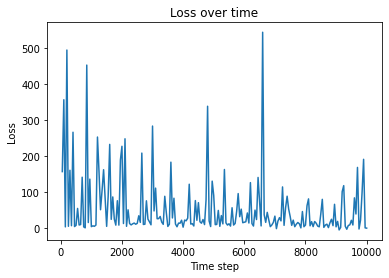

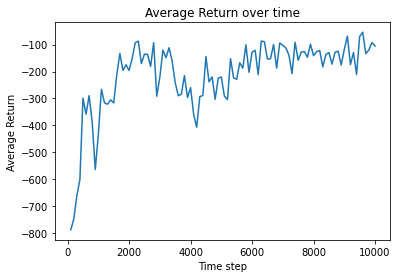

In [18]:
plot_results(actions_taken, losses, average_returns)

### PPO

In [10]:
ppo_actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(100,))
ppo_value_net = value_network.ValueNetwork(train_env.observation_spec())

In [11]:
# Agent
ppo_tf_agent = ppo_agent.PPOAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    actor_net=ppo_actor_net,
    value_net=ppo_value_net,
    num_epochs=10)
ppo_tf_agent.initialize()

In [12]:
# Metrics and Evaluation
ppo_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=ppo_tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
ppo_dataset = ppo_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)
ppo_iterator = iter(ppo_dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [13]:
# Collect data
def collect_episode(environment, policy, num_episodes, replay_buffer):

    episode_counter = 0
    environment.reset()

    while episode_counter < num_episodes:
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1

In [14]:
# Training loop
ppo_tf_agent.train = common.function(ppo_tf_agent.train)
ppo_tf_agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=0>

In [ ]:
# Variables to store data for plotting
ppo_losses = []
ppo_average_returns = []
ppo_episode_lengths = []

# For tracking episode length
ppo_episode_length = 0

# Wrap the training loop in tqdm
print(num_iterations)
# pbar = range(num_iterations)
for _ in (range(num_iterations)):
    # Collect a few episodes using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_episode(train_env, ppo_tf_agent.collect_policy, 1, ppo_replay_buffer)

    # Use data from the buffer and update the agent's network.
    experience, unused_info = next(ppo_iterator)
    train_loss = ppo_tf_agent.train(experience).loss

    step = ppo_tf_agent.train_step_counter.numpy()

    # Store metrics
    # ppo_losses.append(train_loss)
    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
        ppo_losses.append((step, train_loss))
    # Update progress bar
    # pbar.set_description(f'Step: {step}, Loss: {train_loss}')
    
    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      ppo_episode_lengths.append(episode_length)
      ppo_episode_length = 0
    else:
      ppo_episode_length += 1

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, ppo_tf_agent.policy, num_eval_episodes)
        ppo_average_returns.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))

# Print metrics
print(f'Final Loss: {ppo_losses[-1]}')
print(f'Final Average Return: {ppo_average_returns[-1]}')
print(f'Final Average Episode Length: {np.mean(ppo_episode_lengths)}')

10000
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


step = 50: loss = 0.3286018371582031
step = 100: loss = 0.5756421089172363
step = 100: Average Return = -520.5242919921875
step = 150: loss = 4.137384414672852
step = 200: loss = 18.37000846862793
step = 200: Average Return = -375.6787109375
step = 250: loss = 47.3551025390625
step = 300: loss = 64.2192153930664
step = 300: Average Return = -685.83203125
step = 350: loss = 24.768070220947266
step = 400: loss = 24.20982551574707
step = 400: Average Return = -569.797119140625
step = 450: loss = 5.274367809295654
step = 500: loss = 1.6591825485229492
step = 500: Average Return = -475.5708923339844
step = 550: loss = 0.31796932220458984
step = 600: loss = 0.3019571602344513
step = 600: Average Return = -476.6734924316406
step = 650: loss = 0.1875852346420288
step = 700: loss = 2.156442642211914
step = 700: Average Return = -431.9627380371094
step = 750: loss = 0.21700452268123627
step = 800: loss = 0.17525801062583923
step = 800: Average Return = -646.0978393554688
step = 850: loss = 0.221

In [ ]:
plot_average_episode_length(episode_lengths, eval_interval)

In [36]:
def ppo_plot_results(actions_taken, losses, average_returns):
    # Convert actions_taken to a 1D list
    actions_taken = [item[0][0] for item in actions_taken]
    # Plotting losses
    steps, loss_vals = zip(*losses)
    plt.figure()
    plt.plot(steps, loss_vals)
    plt.title('Loss over time')
    plt.xlabel('Time step')
    plt.ylabel('Loss')
    plt.show()

    # Plotting average returns
    steps, avg_returns = zip(*average_returns)
    plt.figure()
    plt.plot(steps, avg_returns)
    plt.title('Average Return over time')
    plt.xlabel('Time step')
    plt.ylabel('Average Return')
    plt.show()

In [40]:
ppo_plot_results(actions_taken, ppo_loss_values_numpy, ppo_average_returns)

TypeError: 'numpy.float32' object is not iterable

In [39]:
ppo_loss_values_numpy = [loss.numpy() for loss in ppo_losses]


In [33]:
len(ppo_average_returns)

203

In [41]:
ppo_average_returns

[-345.82388,
 -270.7404,
 -634.04456,
 -393.49673,
 -373.23383,
 -528.843,
 -373.70074,
 -375.71332,
 -409.827,
 -707.61053,
 -423.03296,
 -409.53995,
 -299.8078,
 -549.3308,
 -438.55362,
 -262.45773,
 -540.66034,
 -264.2724,
 -315.8142,
 -402.41742,
 -466.7089,
 -512.4196,
 -497.35638,
 -421.6066,
 -442.61685,
 -379.96722,
 -344.99835,
 -410.8733,
 -501.39313,
 -398.94086,
 -317.47754,
 -478.36465,
 -516.0613,
 -276.55118,
 -240.33171,
 -368.65848,
 -267.92676,
 -275.10416,
 -403.5798,
 -348.19983,
 -216.11258,
 -454.26938,
 -270.74884,
 -421.23236,
 -360.52084,
 -395.51157,
 -282.6146,
 -282.9669,
 -281.94397,
 -333.6912,
 -188.63168,
 -438.4463,
 -271.44098,
 -363.45035,
 -295.84113,
 -427.99103,
 -521.44904,
 -232.76204,
 -188.4285,
 -375.53677,
 -387.48242,
 -247.33572,
 -294.4567,
 -296.35077,
 -412.5586,
 -217.83394,
 -279.81512,
 -576.4101,
 -155.45813,
 -279.626,
 -150.4976,
 -304.7948,
 -240.44624,
 -239.6925,
 -402.79013,
 -264.7251,
 -213.6468,
 -260.11163,
 -242.40344,
 -2

### DDPG

In [8]:
ddpg_actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(400, 300))

ddpg_critic_net = critic_network.CriticNetwork(
    (train_env.observation_spec(), train_env.action_spec()),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(400, 300))

In [9]:
global_step = tf.compat.v1.train.get_or_create_global_step()

In [10]:
tf_ddpg_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=ddpg_actor_net,
    critic_network=ddpg_critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    ou_stddev=0.2,
    ou_damping=0.15,
    target_update_tau=0.05,
    target_update_period=5,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step)
tf_ddpg_agent.initialize()

In [11]:
ddpg_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000)

In [14]:
for _ in range(100):
    collect_step(train_env, tf_ddpg_agent.collect_policy, ddpg_replay_buffer)

In [15]:
ddpg_dataset = ddpg_replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=64, 
    num_steps=2).prefetch(3)

ddpg_iterator = iter(ddpg_dataset)

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [18]:
# Variables to store data for plotting
actions_taken = []
losses = []
average_returns = []
episode_lengths = []

# For tracking episode length
episode_length = 0
print(num_iterations)
# Assuming `num_iterations` is the total number of training steps
for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, tf_ddpg_agent.collect_policy, ddpg_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(ddpg_iterator)
  train_loss = tf_ddpg_agent.train(experience).loss

  step = tf_ddpg_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_ddpg_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    average_returns.append((step, avg_return))

10000
step = 50: loss = 3.983859062194824
step = 100: loss = 17.82248878479004
step = 100: Average Return = -547.2236938476562
step = 150: loss = 6.208236217498779
step = 200: loss = 65.8424072265625
step = 200: Average Return = -553.48681640625
step = 250: loss = 21.082368850708008
step = 300: loss = 30.738018035888672
step = 300: Average Return = -618.082763671875
step = 350: loss = 34.45498275756836
step = 400: loss = 81.9500503540039
step = 400: Average Return = -572.8997192382812
step = 450: loss = 37.65860366821289
step = 500: loss = 57.14374542236328
step = 500: Average Return = -633.9730834960938
step = 550: loss = 34.84562683105469
step = 600: loss = 17.882442474365234
step = 600: Average Return = -559.7454223632812
step = 650: loss = 75.45433807373047
step = 700: loss = 106.40988159179688
step = 700: Average Return = -530.2491455078125
step = 750: loss = 16.19970703125
step = 800: loss = 122.15290069580078
step = 800: Average Return = -605.5877685546875
step = 850: loss = 283

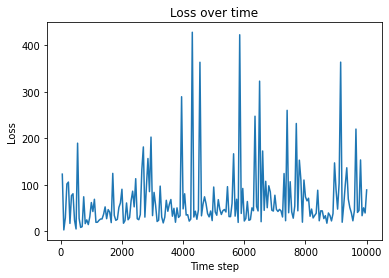

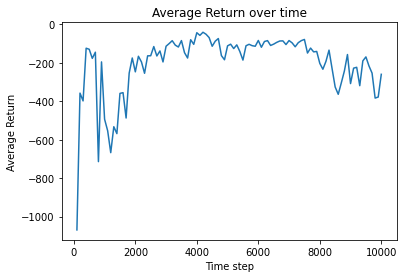

In [18]:
plot_results(actions_taken, losses, average_returns)

In [52]:
# import os
# import gym
# import matplotlib.pyplot as plt
# os.environ["SDL_VIDEODRIVER"] = "dummy"
# from IPython.display import clear_output

# env = gym.make("LunarLanderContinuous-v2")#, render_mode="human")
# env.action_space.seed(42)

# observation, info = env.reset(seed=42, return_info=True)

# for _ in range(10):
#     observation, reward, done, info = env.step(env.action_space.sample())

#     if done:
#         observation, info = env.reset(return_info=True)
        
#     clear_output(wait=True)
#     plt.imshow( env.render(mode='rgb_array') )
#     plt.show()

# env.close()

In [19]:
# import gym
# import imageio
# import os

# # Create the gym environment
# env = gym.make('CartPole-v1')

# # Run the environment and capture frames
# observation = env.reset()
# frames = []
# for t in range(1000000000000):
#     # Render to frames buffer
#     frames.append(env.render(mode="rgb_array"))
#     action = env.action_space.sample()
#     _, _, done, _ = env.step(action)
#     if done:
#         break
# env.close()

# # Save frames as individual images
# output_dir = 'frames'
# os.makedirs(output_dir, exist_ok=True)
# for i, frame in enumerate(frames):
#     imageio.imwrite(f'{output_dir}/frame_{i:04d}.png', frame)

# # Convert images to a video using ffmpeg
# output_video = 'gym_animation.mp4'
# ffmpeg_command = f'ffmpeg -y -r 5 -i {output_dir}/frame_%04d.png -vcodec libx264 -pix_fmt yuv420p {output_video}'
# os.system(ffmpeg_command)

# print(f"Video saved as {output_video}")


In [20]:
# plot_results(actions_taken, losses, average_returns)

## NOW THAT THE DDQN AGENT HAS A BETTER POLICY TO INTERACT WITH THE ENVIRONMENT, LETS COLLECT SOME MORE EXPERIENCES AND STORE IT IN A NEW REPLAY BUFFER. THIS IS THE SET OF EXPERIENECS THAT THE BEHAVIORAL CLONING AGENT WILL LEARN FROM.

In [19]:
# Create a replay buffer to store trajectories
training_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
max_interactions = 10000
num_interactions = 0
counter = 0
while num_interactions < max_interactions:
    print(counter)
    counter += 1
    time_step = train_env.reset()
    episode_step = 0
    while not time_step.is_last():
        action_step = tf_ddpg_agent.collect_policy.action(time_step)  # Use agent's collect_policy
        next_time_step = train_env.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        training_replay_buffer.add_batch(traj)

        time_step = next_time_step
        episode_step += 1
        num_interactions += 1

        if episode_step >= train_env.pyenv.envs[0].env.spec.max_episode_steps:
            break

# Print the number of interactions and replay buffer size
print(f'Number of interactions: {num_interactions}')
print(f'Replay buffer size: {training_replay_buffer.num_frames().numpy()}')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
Number of interactions: 10719
Replay buffer size: 10719


## INITIALIZE BEHAVIORAL CLONING AGENT

In [20]:
observation_spec = train_env.observation_spec()
action_spec = train_env.action_spec()

In [24]:
behavioral_actor_net = actor_network.ActorNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=(400, 300))

In [25]:
# Optimizer
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

In [26]:
# Initialize the Behavioral Cloning Agent
train_step_counter = tf.Variable(0)
agent_b = BehavioralCloningAgent(
    time_step_spec=ts.time_step_spec(observation_spec),
    action_spec=action_spec,
    cloning_network=behavioral_actor_net,
    optimizer=optimizer,
    train_step_counter=train_step_counter)

In [27]:
# Convert the replay buffer to a TensorFlow dataset
experience_dataset = training_replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=64,
    num_steps=1).prefetch(3)

In [28]:
experience_dataset_iterator = iter(experience_dataset)

In [29]:
# Make the Behavioral Cloning Agent's train function a TensorFlow graph function
agent_b.train = common.function(agent_b.train)

In [30]:
# Run the training loop
num_iterations = 20000  # adjust this to your needs
# Create a list to store the loss values
train_loss_list = []
for i in range(num_iterations):
    # Sample a batch of experiences from the replay buffer
    trajectories, _ = next(experience_dataset_iterator)
    
    # Train the agent on the sampled experiences
    train_loss = agent_b.train(trajectories)
    
    # Append the current loss value to the list
    train_loss_list.append(train_loss.loss)
    
    # Print the current iteration number and the training loss every 100 iterations
    if i % 100 == 0:
        print('Iteration:', i, 'Training loss:', train_loss.loss.numpy())

Iteration: 0 Training loss: 0.4217038
Iteration: 100 Training loss: 0.37712365
Iteration: 200 Training loss: 0.4186863
Iteration: 300 Training loss: 0.37483734
Iteration: 400 Training loss: 0.31611556
Iteration: 500 Training loss: 0.417866
Iteration: 600 Training loss: 0.40943956
Iteration: 700 Training loss: 0.4190567
Iteration: 800 Training loss: 0.34992892
Iteration: 900 Training loss: 0.3951759
Iteration: 1000 Training loss: 0.35734248
Iteration: 1100 Training loss: 0.40771198
Iteration: 1200 Training loss: 0.44119775
Iteration: 1300 Training loss: 0.3823383
Iteration: 1400 Training loss: 0.40498003
Iteration: 1500 Training loss: 0.396604
Iteration: 1600 Training loss: 0.32650054
Iteration: 1700 Training loss: 0.40174723
Iteration: 1800 Training loss: 0.4235357
Iteration: 1900 Training loss: 0.39667746
Iteration: 2000 Training loss: 0.3500039
Iteration: 2100 Training loss: 0.44260585
Iteration: 2200 Training loss: 0.34890443
Iteration: 2300 Training loss: 0.3647012
Iteration: 2400 

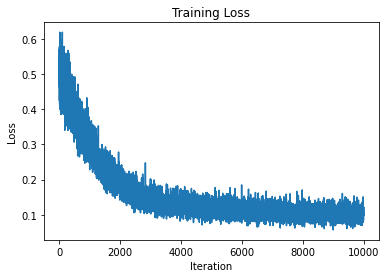

In [33]:
# Plot the training loss
plt.plot(train_loss_list)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

## LET'S FIND OUT IF OUT BEHAVIORAL CLONING AGENT INTERACTS WITH CARTPOLE BETTER AFTER TRAINING ON THE REPLAY BUFFER FULL OF EEXPERIENCES

In [31]:
# Reset the environment
eval_env.reset()

# Initialize variables
total_reward = 0
rewards = []
average_rewards = []
num_eval_episodes = 10000
# Collect rewards by interacting with the environment
for step in range(num_eval_episodes):
    print(step)
    time_step = eval_env.current_time_step()
    while not time_step.is_last():
        # Get the agent's action based on the current time step
        action_step = agent_b.policy.action(time_step)
        
        # Apply the action to the environment
        next_time_step = eval_env.step(action_step.action)
        
        # Collect the reward
        reward = next_time_step.reward
        total_reward += reward
        
        # Update the time step
        time_step = next_time_step
    
    # Append the total reward for the episode
    rewards.append(total_reward)
    total_reward = 0
    
    # Calculate the average reward
    average_reward = sum(rewards) / len(rewards)
    average_rewards.append(average_reward)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

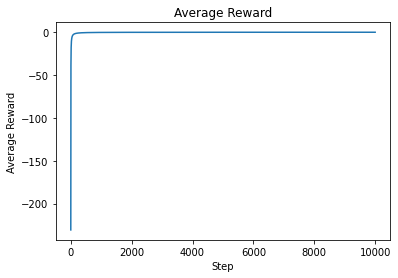

In [36]:
# Plot the final average reward
plt.plot(average_rewards)
plt.title('Average Reward')
plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.show()

In [39]:
# Initialize the Critic Network
behavioral_critic_net = critic_network.CriticNetwork(
    (observation_spec, action_spec),
    observation_fc_layer_params=None,
    action_fc_layer_params=None,
    joint_fc_layer_params=(100,))

In [40]:
behavioral_ddpg_agent = ddpg_agent.DdpgAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=behavioral_actor_net,
    critic_network=behavioral_critic_net,
    actor_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    critic_optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=0.001),
    ou_stddev=0.2,
    ou_damping=0.15,
    target_update_tau=0.05,
    target_update_period=5,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=0.99,
    reward_scale_factor=1.0,
    gradient_clipping=None,
    debug_summaries=False,
    summarize_grads_and_vars=False,
    train_step_counter=global_step)
behavioral_ddpg_agent.initialize()

In [48]:
behavioral_replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=behavioral_ddpg_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=100000)

In [42]:
# Define a function to collect experiences
def collect_experience(environment, policy, buffer, num_episodes):
    counter = 0
    for _ in range(num_episodes):
        print(counter)
        counter += 1
        time_step = environment.reset()
        while not time_step.is_last():
    
            action_step = policy.action(time_step)
            next_time_step = environment.step(action_step.action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            buffer.add_batch(traj)
            time_step = next_time_step

In [49]:
# Collect experiences using the behavioral cloning agent
num_eval_episodes = 100
collect_experience(eval_env, agent_b.policy, behavioral_replay_buffer, num_eval_episodes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [45]:
print("ronak")

ronak


In [50]:
# Reset the train environment
train_env.reset()

TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[ 0.00243635,  1.4117447 ,  0.24675822,  0.03665386, -0.0028163 ,
        -0.05589443,  0.        ,  0.        ]], dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [51]:
# Create an iterator for the replay buffer
behavioral_dataset = behavioral_replay_buffer.as_dataset(num_parallel_calls=3, sample_batch_size=64, num_steps=2)
behavioral_dataset = behavioral_dataset.prefetch(3)
iterator = iter(behavioral_dataset)

In [52]:
# Variables to store data for plotting
behavioral_losses = []
behavioral_average_returns = []
behavioral_episode_lengths = []
# Reset the train step counter
behavioral_ddpg_agent.train_step_counter.assign(0)
# For tracking episode length
episode_length = 0
num_iterations = 2000
# Assuming `num_iterations` is the total number of training steps
for _ in (range(num_iterations)):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent_b.collect_policy, behavioral_replay_buffer)

    # If the episode ended, record its length and reset the count
    time_step = train_env.current_time_step()
    if time_step.is_last():
      behavioral_episode_lengths.append(episode_length)
      episode_length = 0
    else:
      episode_length += 1

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(ddpg_iterator)
  train_loss = behavioral_ddpg_agent.train(experience).loss

  step = behavioral_ddpg_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))
    behavioral_losses.append((step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, behavioral_ddpg_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    behavioral_average_returns.append((step, avg_return))

step = 50: loss = 6.241360187530518
step = 100: loss = 93.17303466796875
step = 100: Average Return = -1945.7086181640625
step = 150: loss = 11.657546997070312
step = 200: loss = 145.36813354492188
step = 200: Average Return = -4788.6025390625
step = 250: loss = 88.30171966552734
step = 300: loss = 23.513233184814453
step = 300: Average Return = -2670.71728515625
step = 350: loss = 21.952171325683594
step = 400: loss = 23.684980392456055
step = 400: Average Return = -2904.74853515625
step = 450: loss = 44.74050521850586
step = 500: loss = 79.27473449707031
step = 500: Average Return = -125.47013854980469
step = 550: loss = 105.84701538085938
step = 600: loss = 10.228713989257812
step = 600: Average Return = -175.60057067871094
step = 650: loss = 21.145519256591797
step = 700: loss = 6.0251874923706055
step = 700: Average Return = -132.25787353515625
step = 750: loss = 116.02953338623047
step = 800: loss = 14.039122581481934
step = 800: Average Return = -131.9737548828125
step = 850: lo

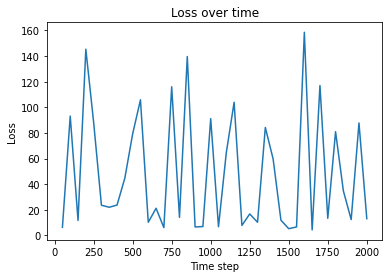

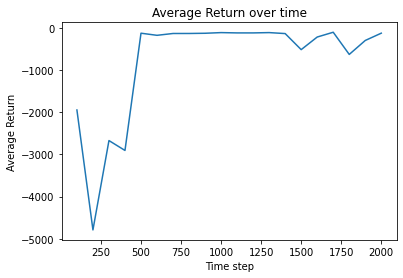

In [57]:
plot_results(behavioral_losses, behavioral_average_returns)